# Variational AutoEncoders (VAE)

Roland Kwitt    
University of Salzburg (2019)

---

In [10]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np


%matplotlib inline
import matplotlib.pyplot as plt

device = "cuda:0"
kwargs = {'num_workers': 1, 'pin_memory': True} 

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data_mnist', 
                   train=True, 
                   download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, 
    shuffle=True, 
    **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data_mnist', 
                   train=False, 
                   transform=transforms.ToTensor()),
    batch_size=128, 
    shuffle=True, 
    **kwargs)

In [18]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1  = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 2)
        self.fc22 = nn.Linear(400, 2)
        self.fc3  = nn.Linear(2, 400)
        self.fc4  = nn.Linear(400, 784)

    # Encoder part q_{\phi}(z|x) - outputs the mean and std. deviation of a 
    # multivariate Gaussian
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    # Reparametrization TRICK
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    # Decoder part p_{\theta}(x|z) - takes in a sample z and 
    # essentially implements \mu_\theta(z), \sigma_\theta(z) 
    # to draw a sample from N(x; \mu_\theta(z), \sigma_\theta(z)*I))
    # Finally, we push the output sample through a sigmoid as we 
    # will use a binary-cross entropy loss
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [19]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(128, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [20]:
for epoch in range(1, 20 + 1):
        train(epoch)
        test(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 553.555420
Train Epoch: 1 [12800/60000 (21%)]	Loss: 199.573807
Train Epoch: 1 [25600/60000 (43%)]	Loss: 181.088913
Train Epoch: 1 [38400/60000 (64%)]	Loss: 177.109116
Train Epoch: 1 [51200/60000 (85%)]	Loss: 166.340912
====> Epoch: 1 Average loss: 190.4492
====> Test set loss: 170.1723
Train Epoch: 2 [0/60000 (0%)]	Loss: 172.379547
Train Epoch: 2 [12800/60000 (21%)]	Loss: 168.023270
Train Epoch: 2 [25600/60000 (43%)]	Loss: 166.984756
Train Epoch: 2 [38400/60000 (64%)]	Loss: 165.179047
Train Epoch: 2 [51200/60000 (85%)]	Loss: 161.049133
====> Epoch: 2 Average loss: 166.8064
====> Test set loss: 164.4591
Train Epoch: 3 [0/60000 (0%)]	Loss: 160.457932
Train Epoch: 3 [12800/60000 (21%)]	Loss: 159.726379
Train Epoch: 3 [25600/60000 (43%)]	Loss: 156.217575
Train Epoch: 3 [38400/60000 (64%)]	Loss: 160.304520
Train Epoch: 3 [51200/60000 (85%)]	Loss: 160.518707
====> Epoch: 3 Average loss: 163.1084
====> Test set loss: 161.9809
Train Epoch: 4 [0/60000 (0%)]	L

In [21]:
with torch.no_grad():
    sample = torch.randn(64, 2).to(device)
    sample = model.decode(sample).cpu()
    save_image(sample.view(64, 1, 28, 28),
               'results/sample_' + str(epoch) + '.png')

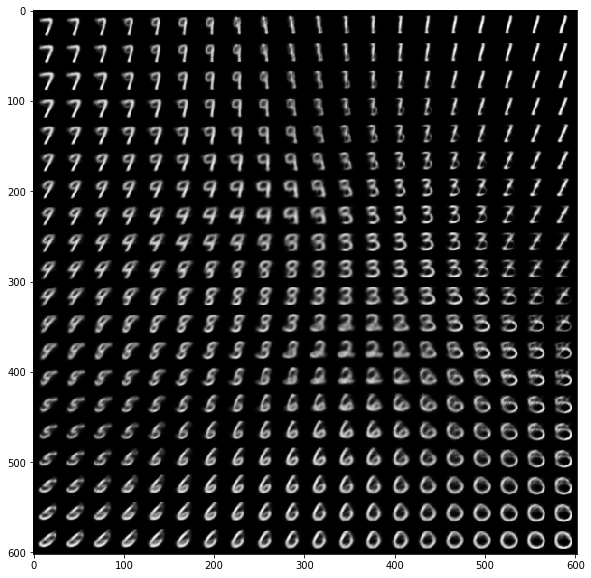

In [23]:
def sample2d(epoch):
    model.eval()
    eps = torch.FloatTensor(400, 2)
    nx = ny = 20
    x_values = np.linspace(-2, 2, nx)
    y_values = np.linspace(-2, 2, ny)
    for i in range(nx):
        for j in range(ny):
            eps[i*20+j][0] = x_values[i]
            eps[i*20+j][1] = y_values[j]
          
    eps = eps.to(device)
    fake = model.decode(eps)
    save_image(fake.view(400, 1, 28, 28),
               'results/grid_' + str(epoch) + '.png', nrow=20)
    
sample2d(50)
im = plt.imread('results/grid_50.png')
plt.figure(figsize=(10,10))
plt.imshow(im)